# **Feasibility Evaluation**

## 0.Loading Pakages

In [149]:
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

## 1.Loading Data (311 Data 2020 to 2024)

In [150]:
data_2020 = pd.read_csv("311_Encampment_Reports2C_2020.csv")
data_2021 = pd.read_csv("311_Encampment_Reports2C_2021.csv")
data_2022 = pd.read_csv("311_Encampment_Reports2C_2022.csv")
data_2023 = pd.read_csv("311_Encampment_Reports2C_2023.csv")
data_2024 = pd.read_csv("311_Encampment_Reports2C_2024.csv")

In [151]:
# Create a dictionary to store all the data
data_dict = {
    2020: data_2020,
    2021: data_2021,
    2022: data_2022,
    2023: data_2023,
    2024: data_2024
}

for year, df in data_dict.items():
    print(f"data_{year}: {df.shape}")

data_2020: (26780, 28)
data_2021: (35644, 26)
data_2022: (54382, 26)
data_2023: (64142, 26)
data_2024: (59059, 26)


In [152]:
# Rename some columns in data_2020
data_2020.rename(columns={"public_des": "public_description",
                         "date_reque": "date_requested",
                         "date_close": "date_closed"}, inplace=True)

In [153]:
# Check the consistency of the columns
for year, df in data_dict.items():
    print(f"{year}: {df.columns}")

2020: Index(['X', 'Y', 'FID', 'service_re', 'service__1', 'sap_notifi',
       'date_requested', 'case_age_d', 'case_recor', 'service_na',
       'service__2', 'date_closed', 'status', 'lat', 'lng', 'street_add',
       'zipcode', 'council_di', 'comm_plan_', 'comm_plan1', 'park_name',
       'case_origi', 'specify_th', 'referred', 'iamfloc', 'floc', 'public_url',
       'public_description'],
      dtype='object')
2021: Index(['x', 'y', 'service_request_id', 'service_request_parent_id',
       'sap_notification_number', 'date_requested', 'case_age_days',
       'case_record_type', 'service_name', 'service_name_detail',
       'date_closed', 'status', 'lat', 'lng', 'street_address', 'zipcode',
       'council_district', 'comm_plan_code', 'comm_plan_name', 'park_name',
       'case_origin', 'referred', 'iamfloc', 'floc', 'public_description',
       'ObjectId'],
      dtype='object')
2022: Index(['x', 'y', 'ÿservice_request_id', 'service_request_parent_id',
       'sap_notification_numbe

## 2.Cleaning Data

In [154]:
def clean_text(df, col_name):
    return (
        df[col_name]
        .fillna("")     #Replaces all missing values with an empty string ""
        .str.lower()    #Converts all text to lowercase
        .str.replace(f"[{string.punctuation}]", "", regex=True) #Removes all punctuation marks from the text
        .str.replace(r"\s+", " ", regex=True) #Replaces multiple spaces or whitespace characters
        .str.strip()    #Removes leading and trailing spaces from each text string
    )

for year, df in data_dict.items():
    df["clean_text"] = clean_text(df, "public_description")
    df["word_count"] = df["clean_text"].str.split().str.len() # count 

## 3. Descriptive Statistics

In [155]:
# Check the number of valid records in the dataset
stats_proportion = []

for year, df in data_dict.items():
    total = len(df)
    non_empty = (df["word_count"] > 0).sum()
    proportion = non_empty / total
    stats_proportion.append([year, total, non_empty, proportion])

summary_df = pd.DataFrame(stats_proportion, columns=["Year", "Total", "Non_Empty", "Proportion"])
print(summary_df)

   Year  Total  Non_Empty  Proportion
0  2020  26780      21654    0.808588
1  2021  35644      32996    0.925710
2  2022  54382      53601    0.985639
3  2023  64142      63824    0.995042
4  2024  59059      58807    0.995733


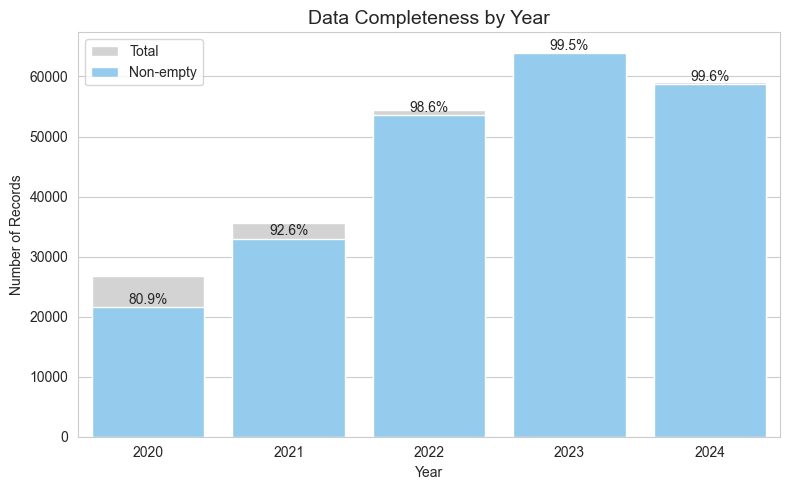

In [156]:
# Visualize
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

sns.barplot(data = summary_df, x = "Year", y = "Total", color = "lightgray", label = "Total")
sns.barplot(data = summary_df, x = "Year", y = "Non_Empty", color = "lightskyblue", label = "Non-empty")

for i, row in summary_df.iterrows():
    plt.text(i, row["Non_Empty"] + 20, f"{row['Proportion']:.1%}",
             ha="center", va="bottom", fontsize=10)

plt.title("Data Completeness by Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.legend()
plt.tight_layout()
plt.show()

In [157]:
# Create time columns
def time_machine(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name], errors="coerce")
    df["month"] = df[col_name].dt.month
    df["day"] = df[col_name].dt.day
    df["date"] = df[col_name].dt.date
    df["time"] = df[col_name].dt.hour + 1

    def get_time_period(row):
        hour = row[col_name].hour
        month = row["month"]
        if 3 <= month <= 9:  
            return "Light" if 6 <= hour < 20 else "Dark"
        else:                
            return "Light" if 6 <= hour < 18 else "Dark"

    df["time_period"] = df.apply(get_time_period, axis=1)
    df["week_type"] = df[col_name].dt.dayofweek.apply(lambda d: "Weekend" if d >= 5 else "Weekday")
    
    return df

for year, df in data_dict.items():
    df = time_machine(df, "date_requested")

In [158]:
# Show the number of reports by time period
summary_time_period = []

for year, df in data_dict.items():
    summary_year = (
        df.groupby("time_period")
          .size() 
          .reset_index(name="count")
    )
    summary_year["Year"] = year
    summary_time_period.append(summary_year)

summary_df = pd.concat(summary_time_period, ignore_index=True)
summary_df

time_period  count  Year
0        Dark   3321  2020
1       Light  23459  2020
2        Dark  19337  2021
3       Light  16307  2021
4        Dark  28567  2022
5       Light  25815  2022
6        Dark  35223  2023
7       Light  28919  2023
8        Dark  32852  2024
9       Light  26207  2024

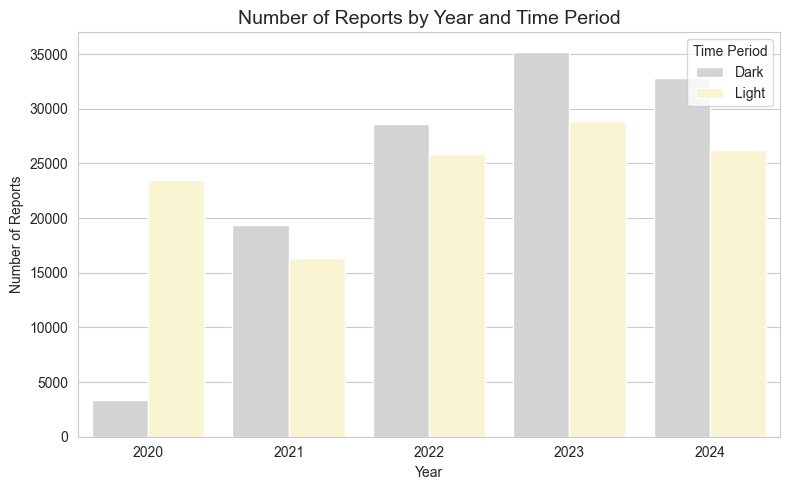

In [159]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

sns.barplot(
    data = summary_df,
    x = "Year",
    y = "count",
    hue = "time_period",
    palette = {"Light": "lemonchiffon", "Dark": "lightgray"}
)

plt.title("Number of Reports by Year and Time Period", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.legend(title="Time Period", loc="upper right")
plt.tight_layout()
plt.show()

In [160]:
# Show the number of reports by week type
summary_week = []

for year, df in data_dict.items():
    daily_counts = (
        df.groupby(["date", "week_type"])
            .size()
            .reset_index(name = "daily_count")
    )

    summary_year = (
        daily_counts.groupby("week_type")["daily_count"]
                    .mean()
                    .reset_index(name="mean_per_day")
    )

    summary_year["Year"] = year
    summary_week.append(summary_year)

summary_df = pd.concat(summary_week, ignore_index=True)
summary_df

week_type  mean_per_day  Year
0   Weekday     57.994429  2020
1   Weekend     44.477612  2020
2   Weekday    107.206897  2021
3   Weekend     73.682692  2021
4   Weekday    164.238462  2022
5   Weekend    111.238095  2022
6   Weekday    188.846154  2023
7   Weekend    143.257143  2023
8   Weekday    172.083969  2024
9   Weekend    134.355769  2024

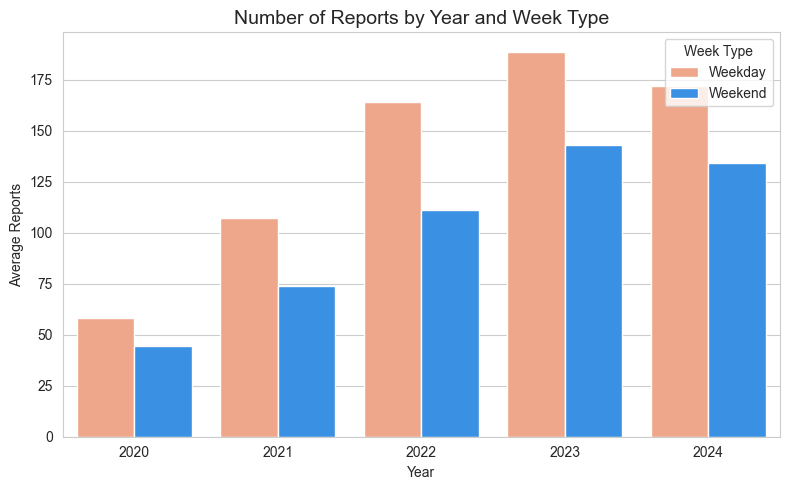

In [161]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

sns.barplot(
    data=summary_df,
    x="Year",
    y="mean_per_day",
    hue="week_type",
    palette={"Weekday": "lightsalmon", "Weekend": "dodgerblue"}
)

plt.title("Number of Reports by Year and Week Type", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Reports")
plt.legend(title="Week Type", loc="upper right")
plt.tight_layout()
plt.show()

In [162]:
# Show the number of reports words by time period
summary_time_period_words = []

for year, df in data_dict.items():
    summary_year = (
        df.groupby("time_period")["word_count"]
          .mean()
          .reset_index()
    )

    summary_year["Year"] = year
    summary_time_period_words.append(summary_year)

In [163]:
summary_df = pd.concat(summary_time_period_words, ignore_index=True)
summary_df

time_period  word_count  Year
0        Dark   18.740440  2020
1       Light   16.710218  2020
2        Dark   17.942597  2021
3       Light   17.295149  2021
4        Dark   17.793118  2022
5       Light   16.946349  2022
6        Dark   15.588678  2023
7       Light   15.192434  2023
8        Dark   19.187568  2024
9       Light   19.162781  2024

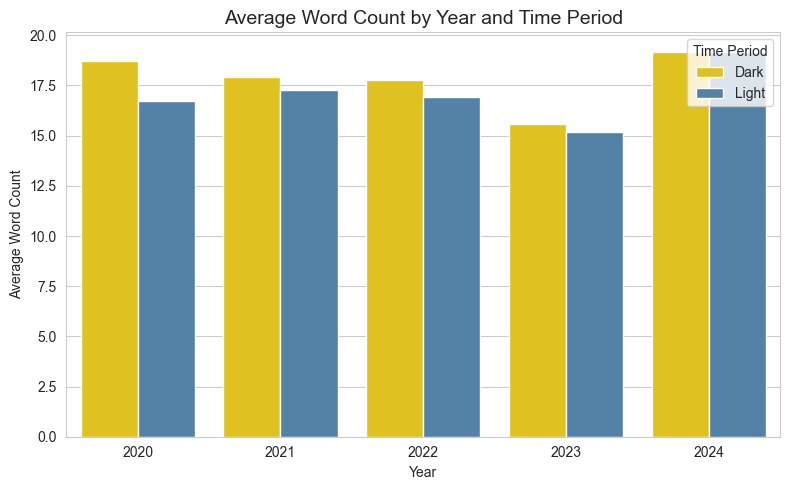

In [164]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

sns.barplot(
    data=summary_df,
    x="Year",
    y="word_count",
    hue="time_period",
    palette=["gold", "steelblue"]
)

plt.title("Average Word Count by Year and Time Period", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Word Count")
plt.legend(title="Time Period", loc="upper right")
plt.tight_layout()
plt.show()

In [165]:
summary_week_word = []

for year, df in data_dict.items():
    summary_year = (
        df.groupby("week_type")["word_count"]
          .mean()
          .reset_index()
    )

    summary_year["Year"] = year
    summary_week_word.append(summary_year)

In [166]:
summary_df = pd.concat(summary_week_word, ignore_index=True)
summary_df

week_type  word_count  Year
0   Weekday   16.970845  2020
1   Weekend   16.931040  2020
2   Weekday   17.684143  2021
3   Weekend   17.508548  2021
4   Weekday   17.685144  2022
5   Weekend   16.316353  2022
6   Weekday   15.896090  2023
7   Weekend   13.823428  2023
8   Weekday   19.552611  2024
9   Weekend   17.963215  2024

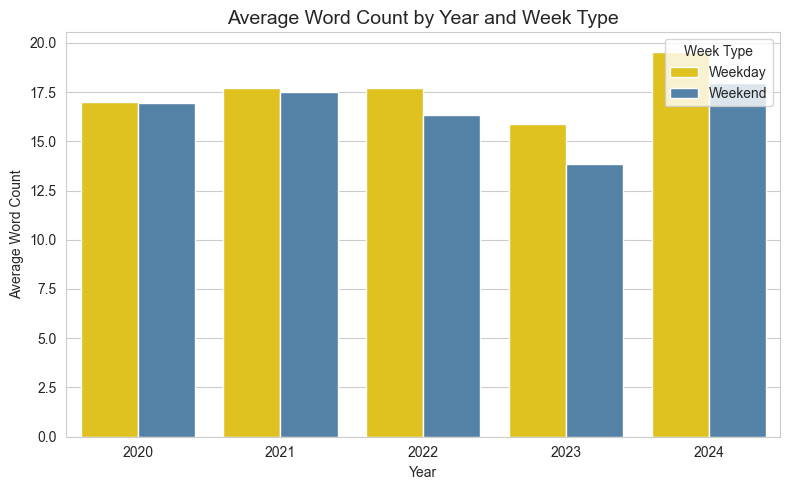

In [167]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

sns.barplot(
    data=summary_df,
    x="Year",
    y="word_count",
    hue="week_type",
    palette=["gold", "steelblue"]
)

plt.title("Average Word Count by Year and Week Type", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Word Count")
plt.legend(title="Week Type", loc="upper right")
plt.tight_layout()
plt.show()

In [168]:
summary_list = []

for year, df in data_dict.items():
    monthly = (
        df.groupby(df["month"])
          .size()
          .reset_index(name="count")
    )

    monthly["Year"] = year
    summary_list.append(monthly)

summary_month = pd.concat(summary_list, ignore_index=True)

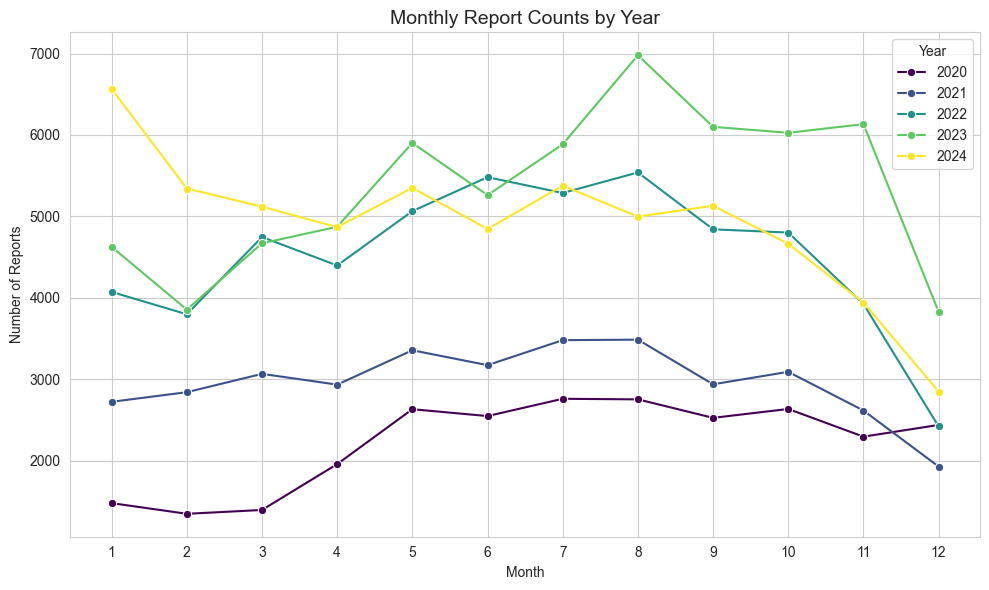

In [169]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

sns.lineplot(
    data=summary_month,
    x="month",
    y="count",
    hue="Year",
    marker="o",
    palette="viridis"
)

plt.title("Monthly Report Counts by Year", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Reports")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.tight_layout()
plt.show()

In [170]:
summary_list = []

for year, df in data_dict.items():
    monthly_avg = (
        df.groupby(df["month"])["word_count"]
          .mean()
          .reset_index(name="avg_word_count")
    )
    
    monthly_avg["Year"] = year
    summary_list.append(monthly_avg)

summary_month_avg = pd.concat(summary_list, ignore_index=True)

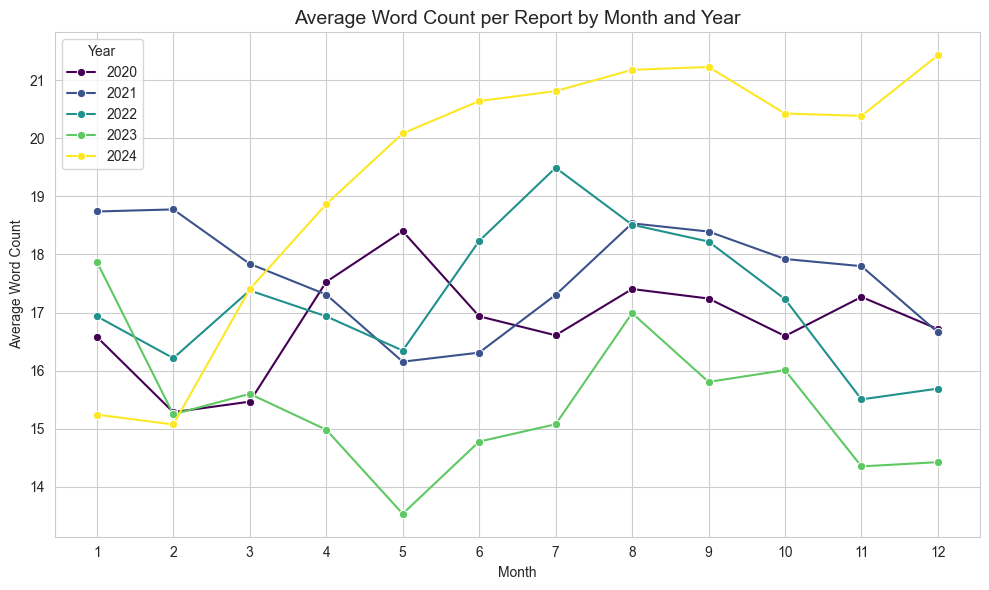

In [171]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

sns.lineplot(
    data=summary_month_avg,
    x="month",
    y="avg_word_count",
    hue="Year",
    marker="o",
    palette="viridis"  
)

plt.title("Average Word Count per Report by Month and Year", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Word Count")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.tight_layout()
plt.show()

## Word frequency

In [172]:
word_freq_dict = {}

for year, df in data_dict.items():
    all_text = " ".join(df["clean_text"])
    words = all_text.split()
    word_freq = Counter(words)
    freq_df = pd.DataFrame(word_freq.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)
    word_freq_dict[year] = freq_df

    print(f"{year} done! {len(freq_df)} unique words.")

2020 done! 15647 unique words.
2021 done! 18093 unique words.
2022 done! 22436 unique words.
2023 done! 23097 unique words.
2024 done! 23890 unique words.


In [173]:
for year, df in data_dict.items():
    print(f"\n=== {year} Top 10 Words ===")
    print(word_freq_dict[year].head(10).to_string(index=False))


=== 2020 Top 10 Words ===
      word  count
       the  20915
       and  15444
        of  11118
        in  10110
        on   8772
         a   8101
        to   7424
        is   7147
  homeless   6543
encampment   6098

=== 2021 Top 10 Words ===
      word  count
       the  28174
       and  21817
        of  14125
encampment  13251
        in  12855
        on  12259
  homeless  11617
        to  11083
         a  10355
        is   9872

=== 2022 Top 10 Words ===
      word  count
       the  41398
       and  33227
  homeless  27259
encampment  20851
        of  19466
        to  18344
        in  18291
        on  17645
         a  14953
        is  13953

=== 2023 Top 10 Words ===
      word  count
       the  42293
       and  34092
  homeless  30105
encampment  24154
        to  20109
        of  19654
        in  18630
        on  18033
         a  15234
        is  14102

=== 2024 Top 10 Words ===
      word  count
       the  49499
       and  39522
  homeless  27037
 

In [174]:
# Remove stopwords
import nltk
nltk.download("stopwords", download_dir = r'C:\Users\User\Desktop\UCSD\2. UCSD CSS Fall 2025\Capstone project')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\Desktop\UCSD\2. UCSD CSS Fall
[nltk_data]     2025\Capstone project...
[nltk_data]   Package stopwords is already up-to-date!


True

In [175]:
from nltk.corpus import stopwords

nltk.data.path.append(r'C:\Users\User\Desktop\UCSD\2. UCSD CSS Fall 2025\Capstone project')
stop_words = set(stopwords.words('english'))

print(f" {len(stop_words)} ")
print(list(stop_words)[:20])

 198 
["aren't", 'out', 'm', 'how', 'over', 'under', 'their', 'yourselves', 'are', 'most', 'aren', 'd', "we've", 'these', 'yours', 'did', 'me', "they're", 'is', 'now']


In [176]:
word_freq_dict = {}

for year, df in data_dict.items():
    all_text = " ".join(df["clean_text"])
    words = all_text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    word_freq = Counter(words)
    freq_df = (
        pd.DataFrame(word_freq.items(), columns=["word", "count"])
        .sort_values(by="count", ascending=False)
        .reset_index(drop=True)
    )
    word_freq_dict[year] = freq_df

    print(f"{year} done! {len(freq_df)} unique words after stopword removal.")

2020 done! 15164 unique words after stopword removal.
2021 done! 17621 unique words after stopword removal.
2022 done! 21929 unique words after stopword removal.
2023 done! 22565 unique words after stopword removal.
2024 done! 23377 unique words after stopword removal.


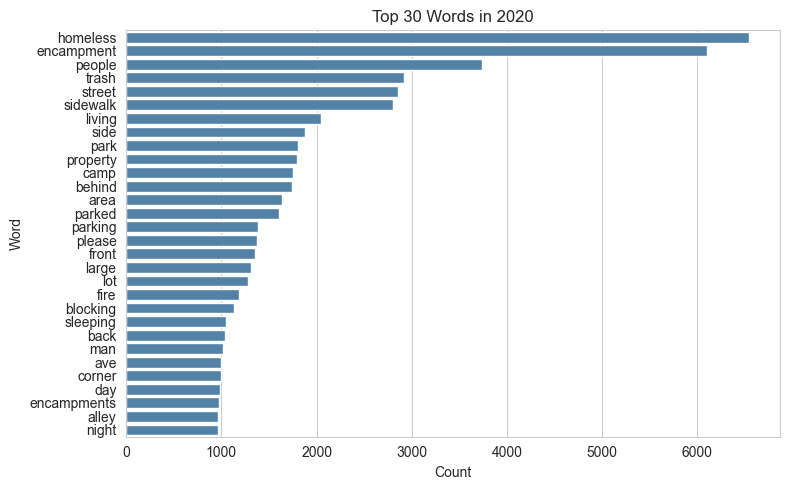

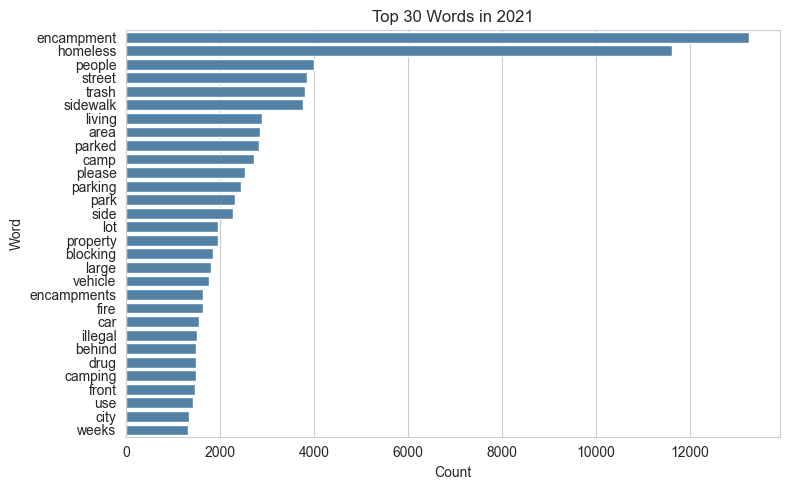

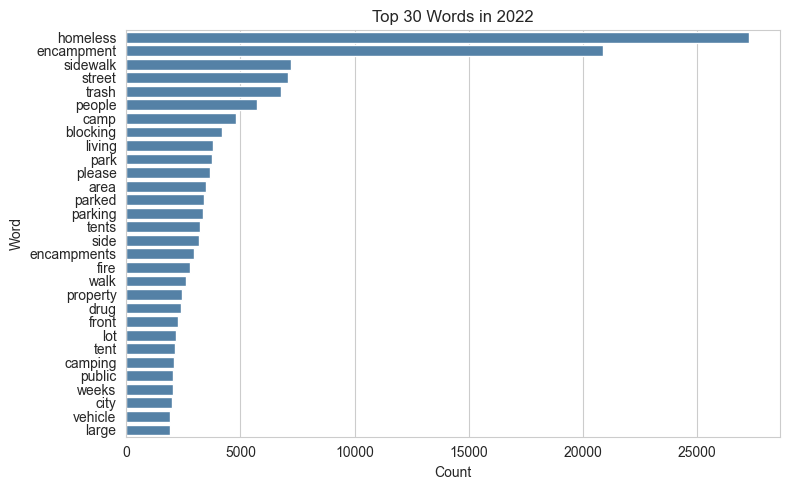

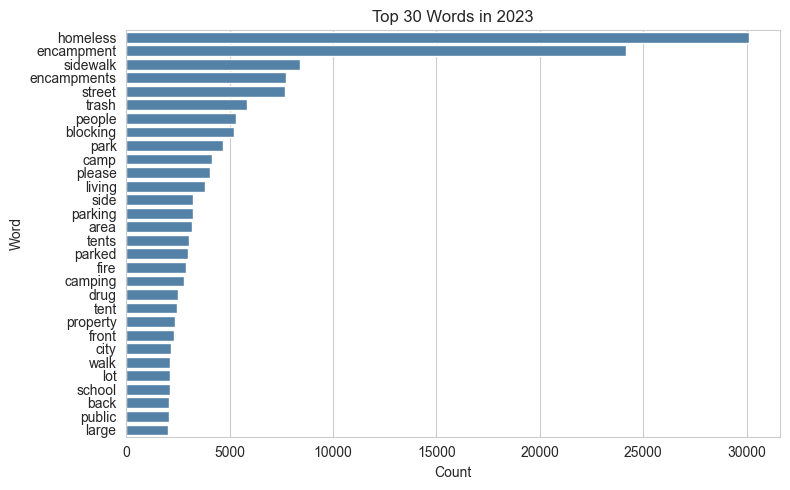

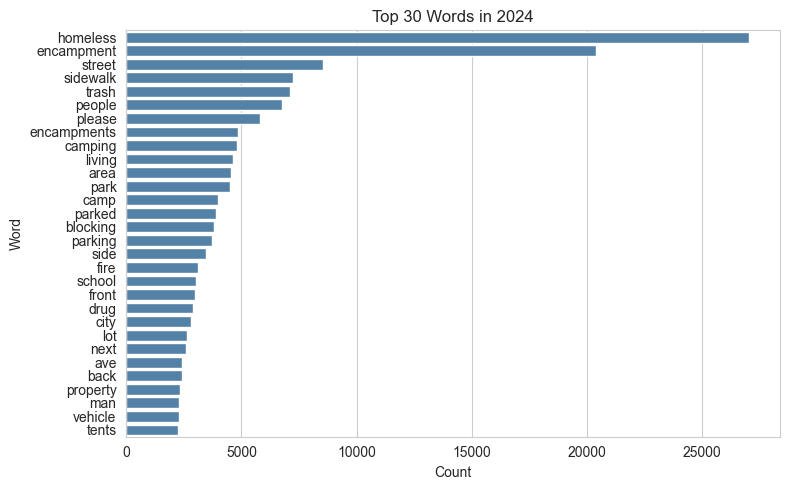

In [177]:
for year, freq_df in word_freq_dict.items():
    plt.figure(figsize=(8,5))
    sns.barplot(data=freq_df.head(30), x="count", y="word", color="steelblue")
    plt.title(f"Top 30 Words in {year}")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

## TF-IDF

In [178]:
#2020
docs = data_2020["clean_text"].tolist()

vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),  
    max_df=0.5,
    min_df=0.01,
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
top_indices = mean_scores.argsort()[-30:][::-1]
top_words = [(feature_names[i], round(mean_scores[i], 4)) for i in top_indices]

print("2020 Top 30 Words:")
for w, s in top_words:
    print(f"{w:<20} {s}")

2020 Top 30 Words:
encampment           0.0704
homeless             0.0668
people               0.0381
sidewalk             0.0344
trash                0.0338
street               0.0306
camp                 0.0257
living               0.0245
behind               0.0231
park                 0.023
property             0.0226
side                 0.0213
parked               0.0197
area                 0.0193
large                0.0186
front                0.0183
parking              0.0175
st                   0.0173
fire                 0.0172
blocking             0.0172
please               0.0169
lot                  0.0164
sleeping             0.0152
encampments          0.0148
alley                0.0147
rp                   0.0147
corner               0.0144
man                  0.0142
ave                  0.0139
near                 0.0138


In [179]:
#2021
docs = data_2021["clean_text"].tolist()

vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),  
    max_df=0.5,
    min_df=0.01,
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
top_indices = mean_scores.argsort()[-30:][::-1]
top_words = [(feature_names[i], round(mean_scores[i], 4)) for i in top_indices]

print("2021 Top 30 Words:")
for w, s in top_words:
    print(f"{w:<20} {s}")

2021 Top 30 Words:
encampment           0.1554
homeless             0.1114
camp                 0.038
sidewalk             0.0346
trash                0.0343
street               0.0289
people               0.0283
living               0.0251
parked               0.0244
parking              0.0236
park                 0.0219
large                0.0204
area                 0.0201
encampments          0.0195
side                 0.0191
blocking             0.019
please               0.0183
fire                 0.0181
vehicle              0.0179
illegal              0.0173
property             0.0172
camping              0.0166
st                   0.016
lot                  0.0159
car                  0.0155
rv                   0.015
behind               0.0148
drug                 0.0147
front                0.0141
tent                 0.0136


In [180]:
#2022
docs = data_2022["clean_text"].tolist()

vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),  
    max_df=0.5,
    min_df=0.01,
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
top_indices = mean_scores.argsort()[-30:][::-1]
top_words = [(feature_names[i], round(mean_scores[i], 4)) for i in top_indices]

print("2022 Top 30 Words:")
for w, s in top_words:
    print(f"{w:<20} {s}")

2022 Top 30 Words:
encampment           0.1762
homeless             0.176
camp                 0.0468
sidewalk             0.0454
trash                0.0394
street               0.0351
blocking             0.0309
people               0.0266
encampments          0.0265
park                 0.0237
living               0.0232
parking              0.0225
parked               0.0217
tents                0.0191
illegal              0.0178
st                   0.0177
fire                 0.0176
please               0.0173
area                 0.0169
drug                 0.0168
camping              0.0166
side                 0.0162
tent                 0.0158
public               0.0153
property             0.015
vehicle              0.0143
front                0.0142
car                  0.0136
large                0.0136
man                  0.0135


In [181]:
#2023
docs = data_2023["clean_text"].tolist()

vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),  
    max_df=0.5,
    min_df=0.01,
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
top_indices = mean_scores.argsort()[-30:][::-1]
top_words = [(feature_names[i], round(mean_scores[i], 4)) for i in top_indices]

print("2023 Top 30 Words:")
for w, s in top_words:
    print(f"{w:<20} {s}")

2023 Top 30 Words:
encampment           0.1799
homeless             0.1795
encampments          0.0825
sidewalk             0.0509
street               0.0365
camp                 0.0347
blocking             0.0344
trash                0.0325
park                 0.028
people               0.0235
living               0.0215
camping              0.0204
tents                0.0197
parking              0.0182
please               0.0179
parked               0.0175
tent                 0.0172
side                 0.0171
illegal              0.0161
fire                 0.0159
drug                 0.0157
st                   0.0155
area                 0.0148
large                0.0147
abandoned            0.0145
property             0.014
front                0.0136
public               0.013
vehicle              0.0121
person               0.012


In [182]:
#2024
docs = data_2024["clean_text"].tolist()

vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),  
    max_df=0.5,
    min_df=0.01,
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
top_indices = mean_scores.argsort()[-30:][::-1]
top_words = [(feature_names[i], round(mean_scores[i], 4)) for i in top_indices]

print("2024 Top 30 Words:")
for w, s in top_words:
    print(f"{w:<20} {s}")

2024 Top 30 Words:
encampment           0.1365
homeless             0.1336
encampments          0.0473
sidewalk             0.044
camping              0.0375
street               0.0364
trash                0.0356
camp                 0.0305
people               0.0284
blocking             0.0258
park                 0.0242
living               0.0237
please               0.0233
parked               0.02
parking              0.0197
area                 0.0197
fire                 0.0181
side                 0.0175
front                0.0168
drug                 0.0168
school               0.0165
vehicle              0.0147
ave                  0.0146
illegal              0.0146
tent                 0.0145
tents                0.0142
next                 0.0139
st                   0.0138
large                0.0136
man                  0.0136


## Sentiment analysis

In [183]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

for year, df in data_dict.items():
    df['compound'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['sentiment'] = df['compound'].apply(
        lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral')
    )
    print(f"{year} finished sentiment analysis")

2020 finished sentiment analysis
2021 finished sentiment analysis
2022 finished sentiment analysis
2023 finished sentiment analysis
2024 finished sentiment analysis


In [184]:
# data_2020.to_csv("data_2020.csv", index=False, encoding="utf-8-sig")
# data_2021.to_csv("data_2021.csv", index=False, encoding="utf-8-sig")
# data_2022.to_csv("data_2022.csv", index=False, encoding="utf-8-sig")
# data_2023.to_csv("data_2023.csv", index=False, encoding="utf-8-sig")
# data_2024.to_csv("data_2020.csv", index=False, encoding="utf-8-sig")

<Figure size 1200x600 with 0 Axes>

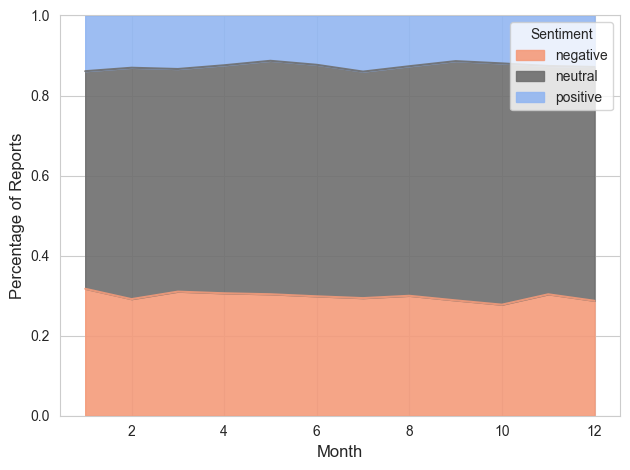

In [185]:
monthly = data_2021.groupby(['month', 'sentiment']).size().unstack(fill_value=0)
monthly_percent = monthly.div(monthly.sum(axis=1), axis=0)

sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

monthly_percent.plot.area(
    color=['#F49B7A', '#6E6E6E', '#92B6F1'],  # negative, neutral, positive
    alpha=0.9
)
plt.ylabel("Percentage of Reports", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.ylim(0, 1)
plt.legend(title="Sentiment", loc="upper right")
plt.tight_layout()
plt.show()

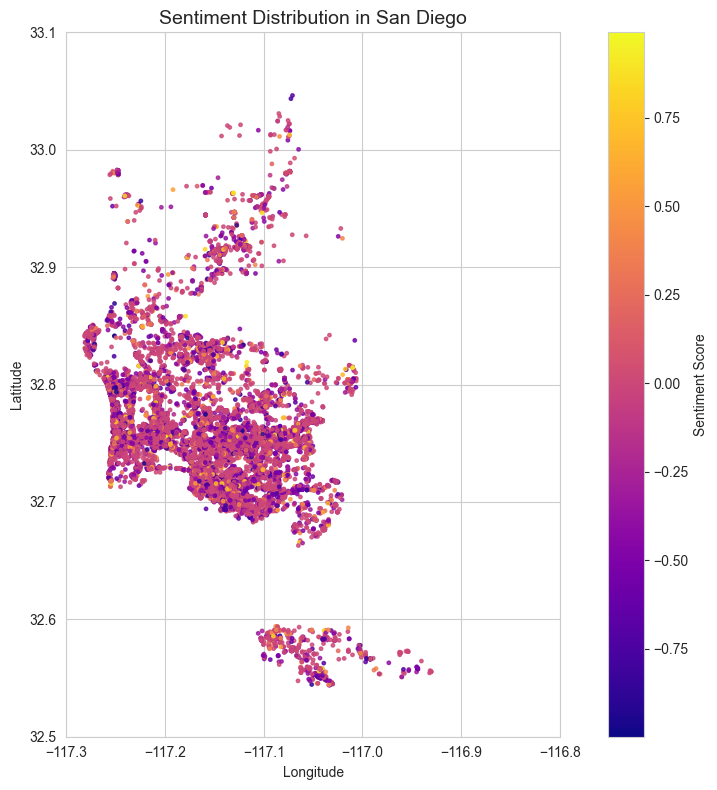

In [186]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    data_2021,
    geometry=gpd.points_from_xy(data_2021['lng'], data_2021['lat']),
    crs="EPSG:4326" 
)

san_diego_bounds = [-117.3, 32.5, -116.8, 33.1] 

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    ax=ax,
    column='compound',
    cmap='plasma',
    markersize=6,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': "Sentiment Score"}
)

ax.set_xlim([-117.3, -116.8])
ax.set_ylim([32.5, 33.1])
ax.set_title("Sentiment Distribution in San Diego", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

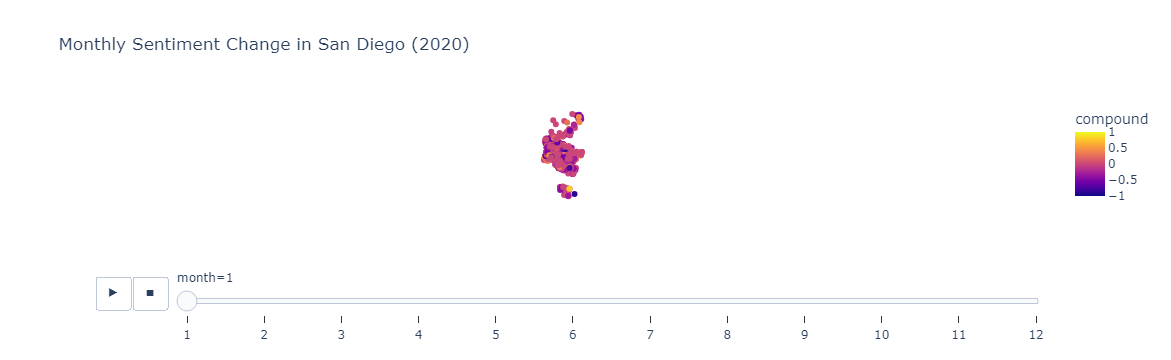

In [187]:
import plotly.express as px

fig = px.scatter_geo(
    data_2021,
    lat='lat',
    lon='lng',
    color='compound',
    color_continuous_scale='plasma',
    hover_name='sentiment',
    animation_frame='month', 
    range_color=(-1, 1),
    scope='usa',
    center={"lat": 32.72, "lon": -117.16},
    title="Monthly Sentiment Change in San Diego (2020)"
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()